In [27]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, accuracy_score

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Параметры обучения

In [28]:

batch_size = 10
epochs = 40
lr = 1e-3
use_amp = True
train_model = True
load_weights = False
save_weights = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Параметры модели

In [29]:
image_channels = 3
block_type = "bottleneck"

Параметры путей

In [30]:
DATASET_PATH = f"./Datasets/cats_vs_dogs"
WEIGHTS_PATH = f"./Weights/cats_vs_dogs/resnet_cats_vs_dogs_b{batch_size}_e{epochs}.pt"
INFERENCE_PATH = f"./Tests/cats_vs_dogs/"

Создание датасета

In [31]:
def random_split_ratio(dataset: torch.utils.data.Dataset,
                       test_size: float = 0.2,
                       random_state: int = 1) -> torch.utils.data.Dataset:
    L = len(dataset)
    n_second = int(L * test_size)
    n_first = L - n_second
    if random_state:
        first_split, second_split = random_split(
            dataset,
            lengths=[n_first, n_second],
            generator=torch.Generator().manual_seed(random_state))
    else:
        first_split, second_split = random_split(dataset,
                                                 lengths=[n_first, n_second])

    return first_split, second_split

In [32]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((120, 120)),
    tv.transforms.ToTensor(),
    tv.transforms.ConvertImageDtype(torch.float32)
])

In [33]:
dataset = tv.datasets.ImageFolder(DATASET_PATH, transform=transform)
train, validate_test = random_split_ratio(dataset, test_size=0.33, random_state=7)
validate, test = random_split_ratio(validate_test, test_size=0.33, random_state=7)

In [34]:
train[1000][0].shape

torch.Size([3, 120, 120])

In [35]:
train.dataset.classes

['Cat', 'Dog']

'Cat'

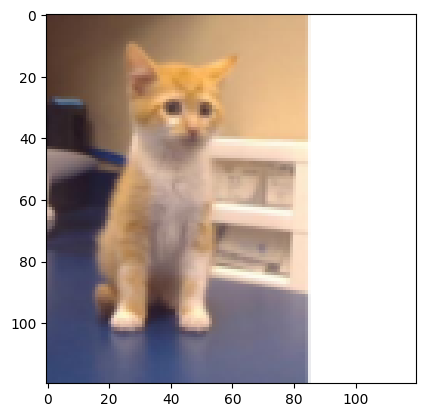

In [36]:
idx = 777
plt.imshow(train[idx][0].permute(1, 2, 0))
train.dataset.classes[train[idx][1]]

In [37]:
train_dataloader = torch.utils.data.DataLoader(
    train, shuffle=True, 
    batch_size=batch_size, num_workers=1, drop_last=False
)
validate_dataloader = torch.utils.data.DataLoader(
    validate, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=False
)
test_dataloader = torch.utils.data.DataLoader(
    test, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=False
)

Вспомогательные функции

In [38]:
def padding_calc(input_matrix_shape: tuple, out_matrix_shape: tuple, kernel_size:tuple, stride:int) -> tuple:

    padding_h = (stride * (out_matrix_shape[0] - 1) - input_matrix_shape[0] +
                 kernel_size[0]) / 2
    padding_w = (stride * (out_matrix_shape[1] - 1) - input_matrix_shape[1] +
                 kernel_size[1]) / 2

    return padding_h, padding_w

In [39]:
def output_shape_calc(input_matrix_shape: tuple, padding: tuple,
                      kernel_size: tuple, stride: int) -> tuple:
    h = (2 * padding[0] - kernel_size[0] + input_matrix_shape[0]) / stride + 1
    w = (2 * padding[1] - kernel_size[1] + input_matrix_shape[1]) / stride + 1

    return h, w

In [40]:
def count_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Архитектура сети

In [41]:
class ResBlock(torch.nn.Module):
    def __init__(self, num_ch: int):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)
        
        self.conv0 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm0 = torch.nn.BatchNorm2d(num_ch)

        self.conv1 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return out + x

In [42]:
class ResBottleneckBlock(torch.nn.Module):
    def __init__(self, num_ch: int):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)

        self.conv0 = torch.nn.Conv2d(num_ch, num_ch//4, kernel_size=1, padding=0)
        self.norm0 = torch.nn.BatchNorm2d(num_ch//4)

        self.conv1 = torch.nn.Conv2d(num_ch//4, num_ch//4, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch//4)

        self.conv2 = torch.nn.Conv2d(num_ch//4, num_ch, kernel_size=1, padding=0)
        self.norm2 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)

        return x + out

In [43]:
class ResStackBlock(torch.nn.Module):
    def __init__(self, num_blocks: int, num_ch: int, block_type="classic"):
        super().__init__()
        stack = []

        for i in range(num_blocks):
            if block_type == "classic":
                stack.append(ResBlock(num_ch))
            elif block_type == "bottleneck":
                stack.append(ResBottleneckBlock(num_ch))
            else:
                raise NotImplementedError(f'{block_type} is not implemented')

        self.stack = torch.nn.Sequential(*stack)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)


In [44]:
class MyResNet(torch.nn.Module):
    def __init__(self, input_ch: int, num_classes: int = 2, num_ch: int = 32, block_type="classic"):
        super().__init__()

        self.conv0 = torch.nn.Conv2d(input_ch, num_ch, kernel_size=7, stride=2)
        self.act = torch.nn.LeakyReLU(0.2)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 =  ResStackBlock(num_blocks=3, num_ch=num_ch, block_type=block_type)
        self.conv1_1 = torch.nn.Conv2d(in_channels=num_ch, out_channels=2*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv1_2 = torch.nn.Conv2d(in_channels=2*num_ch, out_channels=2*num_ch, kernel_size=3, padding=1)
        self.layer2 =  ResStackBlock(num_blocks=3, num_ch=2*num_ch, block_type=block_type)
        self.conv2_1 = torch.nn.Conv2d(in_channels=2*num_ch, out_channels=4*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv2_2 = torch.nn.Conv2d(in_channels=4*num_ch, out_channels=4*num_ch, kernel_size=3, padding=1)
        self.layer3 =  ResStackBlock(num_blocks=5, num_ch=4*num_ch, block_type=block_type)
        self.conv3_1 = torch.nn.Conv2d(in_channels=4*num_ch, out_channels=8*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv3_2 = torch.nn.Conv2d(in_channels=8*num_ch, out_channels=8*num_ch, kernel_size=3, padding=1)
        self.layer4 =  ResStackBlock(num_blocks=2, num_ch=8*num_ch, block_type=block_type)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(8*num_ch, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.act(out)
        out = self.max_pool(out)

        out = self.layer1(out)
        out = self.conv1_1(out)
        out = self.conv1_2(out)

        out = self.layer2(out)
        out = self.conv2_1(out)
        out = self.conv2_2(out)

        out = self.layer3(out)
        out = self.conv3_1(out)
        out = self.conv3_2(out)

        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

Основные функции для обучения и тестирования

In [45]:
def accuracy(pred, label):
  answer = pred.detach().numpy().argmax(1) == label.numpy()
  return answer.mean()

In [46]:
def evaluate(dataloader, model, device):
    preds = []
    labels = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for img, label in (pbar := tqdm(dataloader)):
            img = img.to(device)
            label = label.tolist()

            outs = model(img).detach().cpu()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()

            preds.extend(predictions)
            labels.extend(label)

            pbar.set_description(f'evaluation: ')

    model.train()

    conf_matrix = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)

    return acc, conf_matrix

In [47]:
def train_one_epoch(dataloader,
                    model,
                    optimizer,
                    scaler,
                    loss_fn,
                    metric,
                    device=torch.device('cpu'),
                    use_amp=False):
                    
        for img, label in (pbar := tqdm(dataloader)):
            optimizer.zero_grad()

            img = img.to(device)
            label = label.to(device)

            with autocast(use_amp):
                pred = model(img)
                loss = loss_fn(pred, label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            metric_current = metric(pred.cpu(), label.cpu())
            pbar.set_description(f'metric: {metric_current:.3f}')


In [48]:
def train(train_dataloader,
          validate_dataloader,
          model,
          optimizer,
          loss_fn,
          metric,
          device=torch.device('cpu'),
          epochs=1,
          use_amp=False,
          validate_delay=2):

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        train_one_epoch(train_dataloader, model, optimizer, scaler, loss_fn, metric,
                        device, use_amp)

        if (epoch+1) % validate_delay == 0:
            validate_acc, _ = evaluate(validate_dataloader, model, device)
            print(f"validate accuracy on {epoch+1} epoch: {validate_acc}")


In [49]:
def show_metrics(acc, conf_matrix):
    print(f"cofusion matrix:\n{conf_matrix}\n")
    print(f"accuracy: {acc}")

Обучение сети

In [50]:
model = MyResNet(image_channels, block_type=block_type)
if load_weights:
    model.load_state_dict(torch.load(WEIGHTS_PATH))
model = model.to(device)

In [51]:
count_parameters(model)

1416466

In [52]:
if train_model:
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train(train_dataloader, validate_dataloader, model, optimizer, loss_fn, accuracy, device, epochs, use_amp, 10)

evaluation: : 100%|██████████| 553/553 [00:27<00:00, 20.20it/s]


validate accuracy on 10 epoch: 0.736927808937941


evaluation: : 100%|██████████| 553/553 [00:11<00:00, 48.92it/s]


validate accuracy on 20 epoch: 0.8007960919124298


evaluation: : 100%|██████████| 553/553 [00:11<00:00, 48.55it/s]


validate accuracy on 30 epoch: 0.7827030939026597


evaluation: : 100%|██████████| 553/553 [00:11<00:00, 46.12it/s]

validate accuracy on 40 epoch: 0.8377058078523612


In [53]:
acc, conf_mat = evaluate(test_dataloader, model, device=device)
show_metrics(acc, conf_mat)

evaluation: : 100%|██████████| 273/273 [00:56<00:00,  4.85it/s]

cofusion matrix:
[[1141  218]
 [ 199 1164]]

accuracy: 0.8468038207200588


In [54]:
if save_weights:
    torch.save(model.state_dict(), WEIGHTS_PATH)

In [55]:
def inference_model(inference_data, model):
    inference_images = []
    inference_predictions = []

    for img, label in inference_data:
        inference_images.append(img.permute(1, 2, 0))
        outs = model(img[None,:].to(device)).detach().cpu()
        inference_predictions.append(inference_data.classes[torch.argmax(torch.softmax(outs, 1), 1)])

    return inference_images, inference_predictions

In [56]:
def show_results(n_rows, n_cols, n_samples, inference_images, inference_predictions):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6))
    k = 0

    for j in range(n_rows):
        for i in range(n_cols):
            if k<n_samples:
                axes[j, i].imshow(inference_images[k])
                axes[j, i].set_title(f"Prediction: {inference_predictions[k]}")
                k+=1
            else:
                 fig.delaxes(axes[j, i])
            axes[j, i].get_xaxis().set_visible(False)
            axes[j, i].get_yaxis().set_visible(False)


Результаты работы на "живых данных"

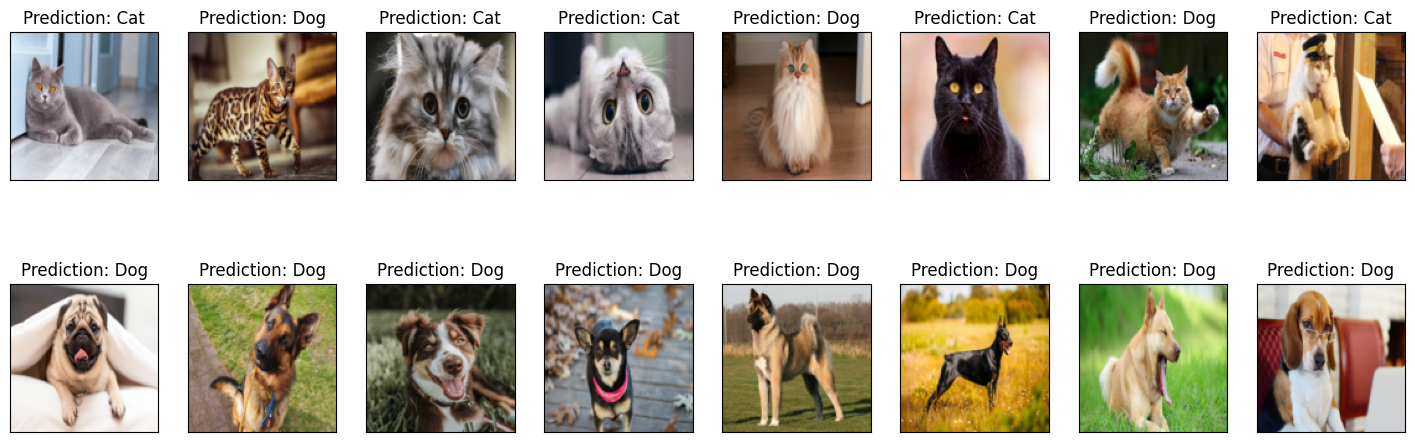

In [57]:
inference_data = tv.datasets.ImageFolder(INFERENCE_PATH, transform=transform)

inference_images, inference_predictions = inference_model(inference_data, model)
show_results(2, 8, 16, inference_images, inference_predictions)
